In [1]:
include("model.jl")
include("Parser.jl")
include("greedy.jl")
include("utils.jl")
using JuMP
using HiGHS

## Data processing

In [ ]:
n, m, x_VC, y_VC, x_loc, y_loc, Q, C, q, f, p, tc, B, R, localities_with_high_priorities, M = parse_instance("./Instances/coord20-5-1_processed.dat")

(50, 5, [42.0, 2.0, 5.0, 14.0, 43.0], [6.0, 39.0, 45.0, 8.0, 3.0], [28.0, 33.0, 45.0, 14.0, 50.0, 17.0, 1.0, 39.0, 8.0, 17.0  …  23.0, 3.0, 15.0, 38.0, 42.0, 12.0, 47.0, 24.0, 14.0, 44.0], [23.0, 5.0, 13.0, 3.0, 32.0, 45.0, 22.0, 36.0, 8.0, 9.0  …  3.0, 49.0, 18.0, 50.0, 31.0, 23.0, 22.0, 24.0, 17.0, 20.0], 70, [420, 420, 350, 350, 350], [19, 17, 19, 18, 14, 19, 20, 13, 11, 16  …  18, 12, 16, 17, 11, 18, 14, 16, 15, 15], [10356, 9744, 5029, 10057, 13647], 1000, 0, 14309.914850942907, [17.41551032843999, 14.606201887781136, 16.384384091012336, 13.689964180456508, 17.33901748690329], [26, 39, 11, 21, 5], 5)

In [3]:
println("Budget: ", B)
println("Q = ", Q)
println("C = ", C)
println("M = ", M)

Budget: 14309.914850942907
Q = 70
C = [420, 420, 350, 350, 350]
M = 5


In [4]:
# Create the distance matrix
distance_matrix = zeros(Float64, m, n)

for i in 1:m 
    for j in 1:n
        distance_matrix[i, j] = sqrt((x_VC[i] - x_loc[j])^2 + (y_VC[i] - y_loc[j])^2)
    end
end


# Create reachability matrix a
A = zeros(Int, m, n)


for i in 1:m
    for j in 1:n
        if distance_matrix[i, j] <= R[i]
            A[i, j] = 1
        end
    end
end

In [5]:
D = zeros(Float64, n+m, n+m)
#The n first rows/cols of D relate to the localities, the m last to the VC
#In other words, calling D[i,j] for i in I, j in J corresponds to call D[i+n,j]
for i in 1:m+n
    for j in 1:m+n
        if i <= n && j <= n
            # Both indices in `loc`
            D[i, j] = sqrt((x_loc[i] - x_loc[j])^2 + (y_loc[i] - y_loc[j])^2)
        elseif i > n && j > n
            # Both indices in `VC`
            D[i, j] = sqrt((x_VC[i - n] - x_VC[j - n])^2 + (y_VC[i - n] - y_VC[j - n])^2)
        elseif i > n && j <= n
            # i in `VC`, j in `loc`
            D[i, j] = sqrt((x_VC[i - n] - x_loc[j])^2 + (y_VC[i - n] - y_loc[j])^2)
        else
            # i in `loc`, j in `VC`
            D[i, j] = sqrt((x_loc[i] - x_VC[j - n])^2 + (y_loc[i] - y_VC[j - n])^2)
        end
    end
end

## Greedy Algorithm

In [6]:
VC, MMTs, Budget, Q_MMTs, Q_tot = greedy_OptVax(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)


(3, [[(53, 53), (53, 21), (21, 11), (11, 26), (26, 39), (39, 53)], [(53, 53), (53, 5), (5, 20), (20, 8), (8, 45), (45, 37), (37, 53)], [(53, 53), (53, 3), (3, 17), (17, 50), (50, 47), (47, 53)], [(53, 53), (53, 30), (30, 1), (1, 48), (48, 12), (12, 53)], [(53, 53), (53, 14), (14, 34), (34, 2), (2, 19), (19, 16), (16, 53)]], 10221.640531100764, [63, 69, 64, 65, 67], 328)

In [7]:
new_MMTs = local_search_2Opt(MMTs, D)

5-element Vector{Vector{Tuple{Int64, Int64}}}:
 [(53, 53), (53, 21), (21, 39), (39, 26), (26, 11), (11, 53)]
 [(53, 53), (53, 8), (8, 20), (20, 5), (5, 45), (45, 37), (37, 53)]
 [(53, 53), (53, 17), (17, 3), (3, 50), (50, 47), (47, 53)]
 [(53, 53), (53, 48), (48, 1), (1, 30), (30, 12), (12, 53)]
 [(53, 53), (53, 19), (19, 2), (2, 16), (16, 14), (14, 34), (34, 53)]

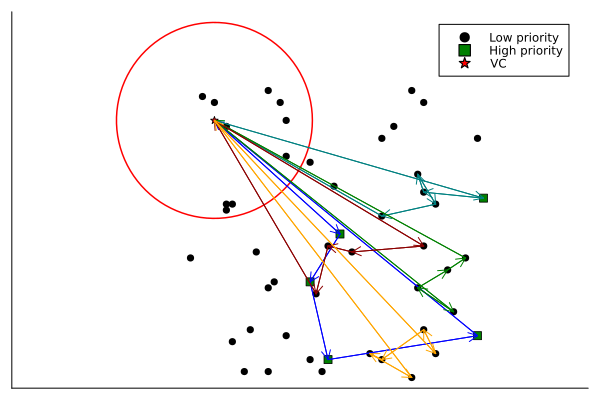

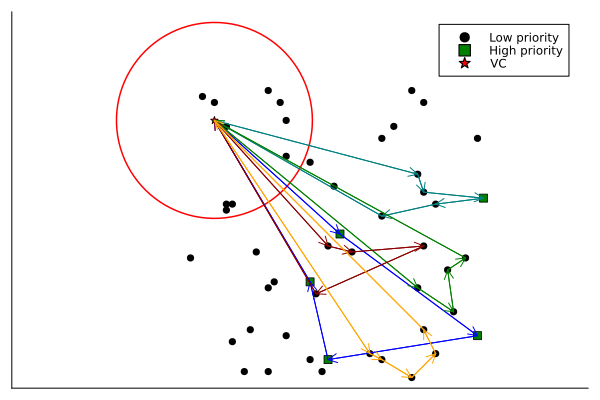

In [8]:
plot_solution_greedy(MMTs, x_VC, y_VC, x_loc, y_loc, R, n, m, M, localities_with_high_priorities)
plot_solution_greedy(new_MMTs, x_VC, y_VC, x_loc, y_loc, R, n, m, M, localities_with_high_priorities)

## Models Creation

### OptVax1

In [ ]:
model_OptVax1 = solve_OptVax1(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)
# greedy_init(model_OptVax1, new_MMTs, VC, M, n, m, q)
optimize!(model_OptVax1)    

obj_val = objective_value(model_OptVax1)
println("Objective Value: ", obj_val)

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+04]
  Cost   [1e+01, 2e+02]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+04]
Assessing feasibility of MIP using primal feasibility and integrality tolerance of       1e-06
Solution has               num          max          sum
Col     infeasibilities      0            0            0
Integer infeasibilities      0            0            0
Row     infeasibilities      0            0            0
Row     residuals            0            0            0
Presolving model
27538 rows, 14956 cols, 128840 nonzeros  0s
26966 rows, 14385 cols, 124358 nonzeros  1s

MIP start solution is feasible, objective value is 475
Objective function is integral with scale 1

Solving MIP model with:
   26966 rows
   14385 cols (14335 binary, 50 integer, 0 implied int., 0 continuous)
   124358 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds           

InterruptException: InterruptException:

### OptVax2

In [10]:
# model_OptVax2 = solve_OptVax2(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)
# greedy_init(model_OptVax2, MMTs, VC, M, n, m, q)
# optimize!(model_OptVax2)


# obj_val = objective_value(model_OptVax2)
# println("Objective Value: ", obj_val)

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+04]
  Cost   [1e+01, 2e+02]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+04]
Assessing feasibility of MIP using primal feasibility and integrality tolerance of       1e-06
Solution has               num          max          sum
Col     infeasibilities      0            0            0
Integer infeasibilities      0            0            0
Row     infeasibilities      0            0            0
Row     residuals            0            0            0
Presolving model
27538 rows, 14956 cols, 128840 nonzeros  0s
26966 rows, 14385 cols, 124358 nonzeros  0s

MIP start solution is feasible, objective value is 475
Objective function is integral with scale 1

Solving MIP model with:
   26966 rows
   14385 cols (14335 binary, 50 integer, 0 implied int., 0 continuous)
   124358 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds           

### OptVax2LP

In [11]:
# model_OptVax2LP = solve_OptVax2LP(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)
# greedy_init(model_OptVax2LP, MMTs, VC, M, n, m, q)
# optimize!(model_OptVax2LP)


# obj_val = objective_value(model_OptVax2LP)
# println("Objective Value: ", obj_val)

In [12]:
# plot_solution(model_OptVax2, x_VC, y_VC, x_loc, y_loc, R,n,m,M, localities_with_high_priorities)